In [1]:
import numpy as np
import pandas as pd

In [2]:
gt_df = pd.read_csv('dataset/MetaCardis_data/test_T2D_metadata.csv')

## FCNN-CF

In [3]:
data = np.load("./Results/FCNN_encoder_confounder_free_plots/test_results.npz")

pred_probs = np.squeeze(data['pred_probs'])
labels = np.squeeze(data['labels'])
sample_ids = data['sample_ids']

pred_df = pd.DataFrame({
            'sample_id': sample_ids,
            'pred_prob': pred_probs,
            'label': labels
            })

df_fcnn_cf = gt_df[['SampleID', 'METFORMIN_C']].merge(pred_df, left_on='SampleID', right_on='sample_id', how='left')

## FCNN

In [4]:
data = np.load("./Results/FCNN_plots/test_results.npz")

pred_probs = np.squeeze(data['pred_probs'])
labels = np.squeeze(data['labels'])
sample_ids = data['sample_ids']

pred_df = pd.DataFrame({
            'sample_id': sample_ids,
            'pred_prob': pred_probs,
            'label': labels
            })

df_fcnn = gt_df[['SampleID', 'METFORMIN_C']].merge(pred_df, left_on='SampleID', right_on='sample_id', how='left')

## MicroKPNN-CF

In [5]:
data = np.load("./Results/MicroKPNN_encoder_confounder_free_plots/test_results.npz")

pred_probs = np.squeeze(data['pred_probs'])
labels = np.squeeze(data['labels'])
sample_ids = data['sample_ids']

pred_df = pd.DataFrame({
            'sample_id': sample_ids,
            'pred_prob': pred_probs,
            'label': labels
            })

df_kpnn_cf = gt_df[['SampleID', 'METFORMIN_C']].merge(pred_df, left_on='SampleID', right_on='sample_id', how='left')

## MicroKPNN

In [6]:
data = np.load("./Results/MicroKPNN_plots/test_results.npz")

pred_probs = np.squeeze(data['pred_probs'])
labels = np.squeeze(data['labels'])
sample_ids = data['sample_ids']

pred_df = pd.DataFrame({
            'sample_id': sample_ids,
            'pred_prob': pred_probs,
            'label': labels
            })

df_kpnn = gt_df[['SampleID', 'METFORMIN_C']].merge(pred_df, left_on='SampleID', right_on='sample_id', how='left')

## Plot!


Combined accuracy results:
   METFORMIN_C  Accuracy       Dataset
0            0  0.712069          FCNN
1            1  0.777778          FCNN
2            0  0.796552       FCNN-CF
3            1  0.859259       FCNN-CF
4            0  0.775862     MicroKPNN
5            1  0.866667     MicroKPNN
6            0  0.786207  MicroKPNN-CF
7            1  0.851852  MicroKPNN-CF


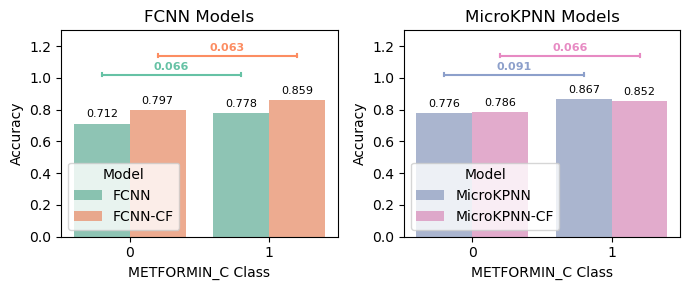

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to process each dataframe
def process_dataframe(df, df_name):
    # Clean data
    df_clean = df.dropna(subset=['pred_prob', 'label'])
    
    if df_clean.empty:
        print(f"Warning: All prediction/label data appears to be NaN in {df_name}.")
        return None
    
    # Convert predictions to binary (assuming threshold of 0.5)
    df_clean['pred_binary'] = (df_clean['pred_prob'] > 0.5).astype(int)
    
    # Calculate accuracy for each METFORMIN_C class
    accuracy_by_class = df_clean.groupby('METFORMIN_C').apply(
        lambda x: (x['pred_binary'] == x['label']).mean(), include_groups=False
    ).reset_index()
    accuracy_by_class.columns = ['METFORMIN_C', 'Accuracy']
    accuracy_by_class['Dataset'] = df_name
    
    return accuracy_by_class

# Process all four dataframes
results1 = process_dataframe(df_fcnn, 'FCNN')
results2 = process_dataframe(df_fcnn_cf, 'FCNN-CF')
results3 = process_dataframe(df_kpnn, 'MicroKPNN')  
results4 = process_dataframe(df_kpnn_cf, 'MicroKPNN-CF') 

# Combine all results that are valid
valid_results = [r for r in [results1, results2, results3, results4] if r is not None]
combined_results = pd.concat(valid_results, ignore_index=True)
print("\nCombined accuracy results:")
print(combined_results)

# Get SET2 colors from matplotlib
set2_colors = plt.cm.Set2.colors

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))

# Filter data for each subplot
fcnn_data = combined_results[combined_results['Dataset'].isin(['FCNN', 'FCNN-CF'])]
kpnn_data = combined_results[combined_results['Dataset'].isin(['MicroKPNN', 'MicroKPNN-CF'])]

# Plot 1: FCNN models
sns.barplot(data=fcnn_data, x='METFORMIN_C', y='Accuracy', hue='Dataset', 
            palette=[set2_colors[0], set2_colors[1]], alpha=0.8, ax=ax1)
ax1.set_xlabel('METFORMIN_C Class')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1.3)
ax1.set_title('FCNN Models')
ax1.legend(title='Model')

# Add value labels on bars for subplot 1
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.3f', padding=3, fontsize=8)

# Calculate and annotate gap for FCNN models
fcnn_datasets = fcnn_data['Dataset'].unique()
for i, dataset in enumerate(fcnn_datasets):
    dataset_data = fcnn_data[fcnn_data['Dataset'] == dataset]
    
    # Get accuracy for METFORMIN_C 0 and 1
    acc_0 = dataset_data[dataset_data['METFORMIN_C'] == 0]['Accuracy'].iloc[0]
    acc_1 = dataset_data[dataset_data['METFORMIN_C'] == 1]['Accuracy'].iloc[0]
    
    # Calculate gap (class 1 - class 0)
    gap = acc_1 - acc_0
    
    # Position annotation at different x positions for each model
    x_positions = [-0.2, 0.2]  # Offset positions for 2 models
    x_pos = 0.5 + x_positions[i]  # Center between class 0 and 1, with offset
    
    # Progressively increasing y-position for each model
    y_pos = 1.0 + (i * 0.12)
    
    # Draw significance line
    line_y = y_pos + 0.02
    ax1.plot([0 + x_positions[i], 1 + x_positions[i]], [line_y, line_y], 
            color=set2_colors[i], linewidth=1.5)
    
    # Add vertical bars at the ends
    ax1.plot([0 + x_positions[i], 0 + x_positions[i]], [line_y - 0.01, line_y + 0.01], 
            color=set2_colors[i], linewidth=1.5)
    ax1.plot([1 + x_positions[i], 1 + x_positions[i]], [line_y - 0.01, line_y + 0.01], 
            color=set2_colors[i], linewidth=1.5)
    
    # Add gap annotation above the line
    ax1.text(x_pos, line_y + 0.02, f'{abs(gap):.3f}', 
           ha='center', va='bottom',
           fontsize=8,
           color=set2_colors[i],
           fontweight='bold')

# Plot 2: MicroKPNN models
sns.barplot(data=kpnn_data, x='METFORMIN_C', y='Accuracy', hue='Dataset', 
            palette=[set2_colors[2], set2_colors[3]], alpha=0.8, ax=ax2)
ax2.set_xlabel('METFORMIN_C Class')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1.3)
ax2.set_title('MicroKPNN Models')
ax2.legend(title='Model')

# Add value labels on bars for subplot 2
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.3f', padding=3, fontsize=8)

# Calculate and annotate gap for MicroKPNN models
kpnn_datasets = kpnn_data['Dataset'].unique()
for i, dataset in enumerate(kpnn_datasets):
    dataset_data = kpnn_data[kpnn_data['Dataset'] == dataset]
    
    # Get accuracy for METFORMIN_C 0 and 1
    acc_0 = dataset_data[dataset_data['METFORMIN_C'] == 0]['Accuracy'].iloc[0]
    acc_1 = dataset_data[dataset_data['METFORMIN_C'] == 1]['Accuracy'].iloc[0]
    
    # Calculate gap (class 1 - class 0)
    gap = acc_1 - acc_0
    
    # Position annotation at different x positions for each model
    x_positions = [-0.2, 0.2]  # Offset positions for 2 models
    x_pos = 0.5 + x_positions[i]  # Center between class 0 and 1, with offset
    
    # Progressively increasing y-position for each model
    y_pos = 1.0 + (i * 0.12)
    
    # Draw significance line
    line_y = y_pos + 0.02
    ax2.plot([0 + x_positions[i], 1 + x_positions[i]], [line_y, line_y], 
            color=set2_colors[i+2], linewidth=1.5)
    
    # Add vertical bars at the ends
    ax2.plot([0 + x_positions[i], 0 + x_positions[i]], [line_y - 0.01, line_y + 0.01], 
            color=set2_colors[i+2], linewidth=1.5)
    ax2.plot([1 + x_positions[i], 1 + x_positions[i]], [line_y - 0.01, line_y + 0.01], 
            color=set2_colors[i+2], linewidth=1.5)
    
    # Add gap annotation above the line
    ax2.text(x_pos, line_y + 0.02, f'{abs(gap):.3f}', 
           ha='center', va='bottom',
           fontsize=8,
           color=set2_colors[i+2],
           fontweight='bold')

plt.tight_layout()
plt.show()